## GA demystified for cosmological parameter estimation: changing fitness

In this notebook, we use `pygad` to obtain parameter samples in a curved $\Lambda$ CDM model generated with genetic algorithm, varying the fitness functions. See [arXiv:2505.10450](https://arxiv.org/abs/2505.10450).

The results obtained in this notebook can be analyzed with the notebook `CosmoGA_Analysis.ipynb`.

In [1]:
import os, sys
import numpy as np
from numpy.linalg import inv
from scipy.linalg import block_diag
from astropy.cosmology import LambdaCDM

from numpy.random import uniform as U # uniform distribution

import matplotlib.pyplot as plt
import corner # for presentation

from scipy.optimize import minimize
import time

import pygad # GA python library

### 1. Load data sets

In [17]:
# import the data points
filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/HzTable_MM_BC03.dat'
z_cc, Hz_cc, errHz_cc = np.genfromtxt(filename, comments = '#', usecols = (0,1,2), \
                                      unpack = True, delimiter = ',')
# above error bars for plotting only; use full covariance matrix to estimate cosmo params

# import and calculate covariance matrix
# import CC covariance matrix data

filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments = '#', \
                                             usecols = (0,1,2,3,4), unpack = True)

# calculate CC covariance matrix
cov_mat_diag = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')

for i in range(len(z_cc)):
    cov_mat_diag[i,i] = errHz_cc[i]**2

imf_intp = np.interp(z_cc, zmod, imf)/100
slib_intp = np.interp(z_cc, zmod, slib)/100
sps_intp = np.interp(z_cc, zmod, sps)/100
spsooo_intp = np.interp(z_cc, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_slib = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_sps = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_spsooo = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')

for i in range(len(z_cc)):
    for j in range(len(z_cc)):
        cov_mat_imf[i,j] = Hz_cc[i] * imf_intp[i] * Hz_cc[j] * imf_intp[j]
        cov_mat_slib[i,j] = Hz_cc[i] * slib_intp[i] * Hz_cc[j] * slib_intp[j]
        cov_mat_sps[i,j] = Hz_cc[i] * sps_intp[i] * Hz_cc[j] * sps_intp[j]
        cov_mat_spsooo[i,j] = Hz_cc[i] * spsooo_intp[i] * Hz_cc[j] * spsooo_intp[j]

C_cc = cov_mat_spsooo + cov_mat_imf + cov_mat_diag # full CC covariance
C_cc_inv = inv(C_cc)


# import supernovae data
loc_lcparam = 'https://github.com/PantheonPlusSH0ES/DataRelease/raw/main/\
Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat'

# pantheon plus systematics
lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11))

# setup pantheon samples with z > 0.01
z_pp = lcparam[:, 0][111:]
mMz_pp = lcparam[:, 3][111:]
sigmMz_pp = lcparam[:, 4][111:]

# load the pantheon+ covariance matrix

loc_lcparam_sys = 'https://raw.githubusercontent.com/PantheonPlusSH0ES/\
DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov'

lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# pantheon plus systematics
C_sne = lcparam_sys.reshape(1701, 1701)
C_sne_inv = np.linalg.inv(C_sne[111:, 111:])

The data are visualized below;

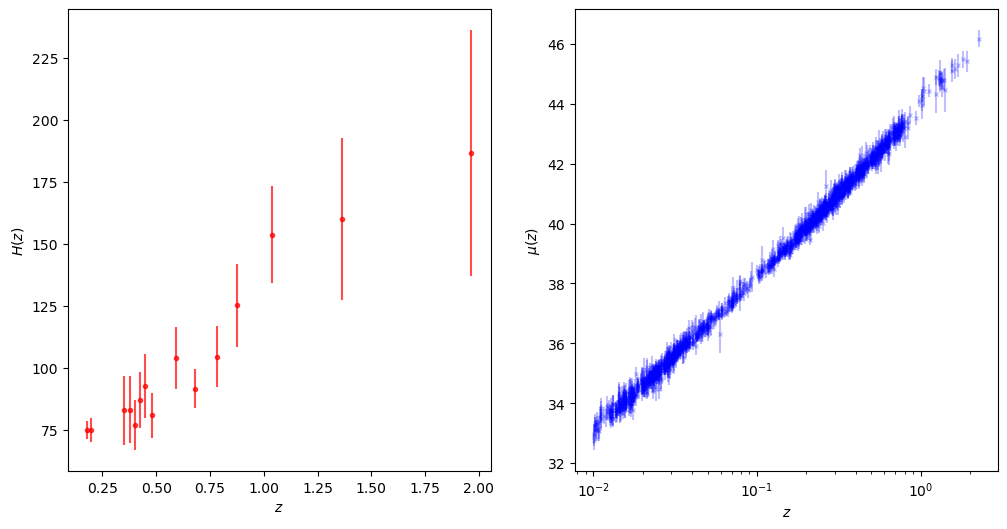

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
ax[0].errorbar(z_cc, Hz_cc, yerr = errHz_cc, fmt = 'ro', markersize = 3, alpha=0.7)
ax[0].set_xlabel(r'$z$'); ax[0].set_ylabel(r'$H(z)$')
# ax[0].grid(True, alpha=0.2)

ax[1].errorbar(z_pp, mMz_pp, yerr = sigmMz_pp, fmt = 'bx', markersize = 3, alpha=0.25)
ax[1].set_xscale('log')
ax[1].set_xlabel('$z$'); ax[1].set_ylabel('$\mu(z)$')
# ax[1].grid(True, alpha=0.2)
plt.show()

### 2. Cosmology: Curved $\Lambda$ CDM

We use `astropy` to generate cosmological predictions as well as to setup the likelihood. A quick test calculation is shown below together with the data;

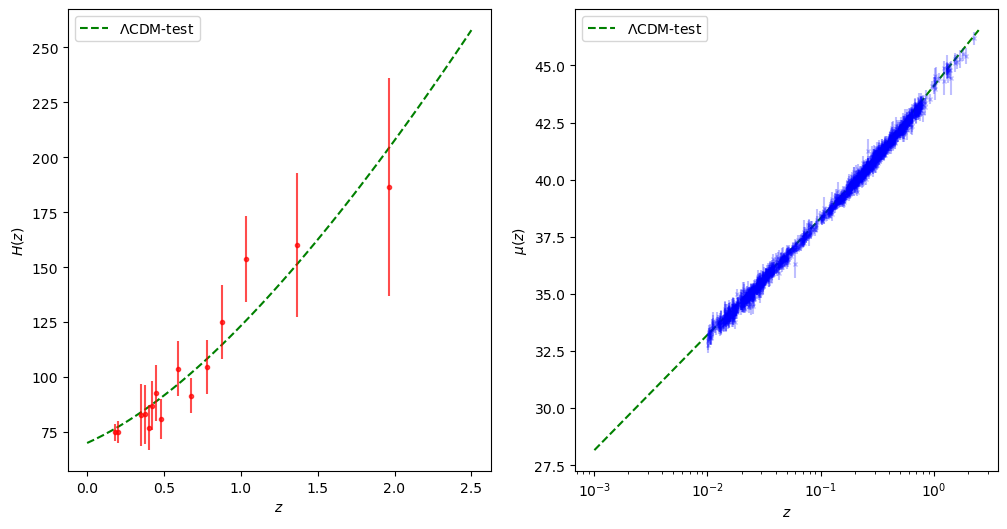

In [19]:
z_test = np.linspace(1e-3, 2.5) # cosmological redshifts

# test cosmology
H0_test, Om0_test, Ok0_test = 70, 0.3, 0.0
cosmo = LambdaCDM(H0 = H0_test, Om0 = Om0_test, Ode0 = 1-Om0_test-Ok0_test)
Hz_test = cosmo.H(z_test).value
mMz_test = cosmo.distmod(z_test).value

fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
ax[0].plot(z_test, Hz_test, 'g--', label = r'$\Lambda$CDM-test')
ax[0].errorbar(z_cc, Hz_cc, yerr = errHz_cc, fmt = 'ro', markersize = 3, alpha=0.7)
ax[0].set_xlabel(r'$z$'); ax[0].set_ylabel(r'$H(z)$')
ax[0].legend(loc = 'upper left')

ax[1].plot(z_test, mMz_test, 'g--', label = r'$\Lambda$CDM-test')
ax[1].errorbar(z_pp, mMz_pp, yerr = sigmMz_pp, fmt = 'bx', markersize = 3, alpha=0.25)
ax[1].set_xscale('log')
ax[1].set_xlabel('$z$'); ax[1].set_ylabel('$\mu(z)$')
ax[1].legend(loc = 'upper left')

plt.show()

The likelihoods and flat priors are setup in the following;

In [20]:
def Chi2_CC(x):
    # H0, Om0, Ok0 = x
    # cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0)
    H0, Om0, Ode0 = x
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    dev_cc = Hz_cc - cosmo.H(z_cc).value
    return dev_cc.T @ C_cc_inv @ dev_cc

def Chi2_SNe(x):
    # H0, Om0, Ok0 = x
    # cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0)
    H0, Om0, Ode0 = x
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    dev_sne = mMz_pp - cosmo.distmod(z_pp).value
    return dev_sne.T @ C_sne_inv @ dev_sne


# flat priors
H0_min, H0_max = 0, 100
Om0_min, Om0_max = 0, 1
Ode0_min, Ode0_max = 0, 1

def llflatprior(x):
    H0, Om0, Ode0 = x
    # if (H0_min < H0 < H0_max and Om0_min < Om0 < Om0_max \
    #     and Ok0_min < Ok0 < Ok0_max):
    if (H0_min < H0 < H0_max and Om0_min < Om0 < Om0_max \
        and Ode0_min < Ode0 < Ode0_max):
        return 0.0
    return -np.inf

def llprob_CC(x):
    H0, Om0, Ode0 = x
    if (Om0 < 0) or (H0 < 0):
        return -np.inf
    lp = llflatprior(x)
    lk = -0.5*Chi2_CC(x)
    if np.isnan(lk):
        return -np.inf
    return lp + lk if np.isfinite(lp) else -np.inf

def llprob_CCSNe(x):
    H0, Om0, Ode0 = x
    if (Om0 < 0) or (H0 < 0):
        return -np.inf
    lp = llflatprior(x)
    lk = -0.5*(Chi2_CC(x) + Chi2_SNe(x))
    if np.isnan(lk):
        return -np.inf
    return lp + lk if np.isfinite(lp) else -np.inf

### 3. GA: Changing Fitness Function

This section shows how to generate and analyze a population using an instance of `pygad`. This furthermore shows how the GA hyperparameters are set up to analyze the data;

#### 3.1 CC Only

Consider the forms of the fitness function given below (feel free to play with these functional forms);

In [21]:
def fitness_func_0(ga_instance, chromosome, chromosome_idx):
    return llprob_CC(chromosome)

def fitness_func_1(ga_instance, chromosome, chromosome_idx):
    chi2 = -2*llprob_CC(chromosome)
    return 100/chi2

def fitness_func_2(ga_instance, chromosome, chromosome_idx):
    return np.exp(llprob_CC(chromosome))

Now we initialize the population by uniform sampling over the priors;

In [22]:
# setup the population size and the initial population
pop_size = 3000
init_uni = np.array([[U(H0_min, H0_max), U(Om0_min, Om0_max), U(Ode0_min, Ode0_max)] \
                     for i in np.arange(pop_size)])

# parameter spaces
gene_space = [{'low': H0_min, 'high': H0_max}, \
              {'low': Om0_min, 'high': Om0_max}, {'low': Ode0_min, 'high': Ode0_max}]

The hyperparameters that determine the GA operators are now configured in the following lines;

In [28]:
num_genes = 3 # length of chromosome

n_gen = 100 # number of generations
sel_rate = 0.3 # selection rate

# parent selection
parent_selection_type = "rws" # roulette wheel selection
keep_parents = int(sel_rate*pop_size)
num_parents_mating = int(sel_rate*pop_size)

# crossover options: single_point, two_points, uniform
crossover_type = "scattered"
crossover_prob = 0.5

# mutation type options: random, swap, inversion, scramble, adaptive
mutation_type = "adaptive"
mutation_prob = [0.5, 0.3] # if adaptive, two numbers as [a, b]

def on_gen(ga_instance): # print results every N = 10 generations
    generation_count = ga_instance.generations_completed
    if generation_count % 10 == 0:
        print("Generation:", generation_count)
        # print("Fitness of the best solution:", ga_instance.best_solution()[1])

The `pygad` instances (GA results) are now obtained as follows;

In [ ]:
# setup GA instance, for random initial pop.
ga_instance = pygad.GA(initial_population = init_uni,
                       num_genes = num_genes,
                       num_generations = n_gen,
                       num_parents_mating = num_parents_mating,
                       fitness_func = fitness_func_0,
                       parent_selection_type = parent_selection_type,
                       keep_parents = keep_parents,
                       crossover_type = crossover_type,
                       crossover_probability = crossover_prob,
                       mutation_type = mutation_type,
                       mutation_probability = mutation_prob,
                       on_generation = on_gen,
                       gene_space = gene_space,
                       parallel_processing = 20)
                       # save_best_solutions = True # to save solutions per gen.

# perform GA run and save results
ga_instance.run()
ga_instance.save(filename='ga_cc_fitness_0')

######## fitness 1 #########

ga_instance = pygad.GA(initial_population = init_uni,
                       num_genes = num_genes,
                       num_generations = n_gen,
                       num_parents_mating = num_parents_mating,
                       fitness_func = fitness_func_1,
                       parent_selection_type = parent_selection_type,
                       keep_parents = keep_parents,
                       crossover_type = crossover_type,
                       crossover_probability = crossover_prob,
                       mutation_type = mutation_type,
                       mutation_probability = mutation_prob,
                       on_generation = on_gen,
                       gene_space = gene_space,
                       parallel_processing = 20)
                       # save_best_solutions = True # to save solutions per gen.

# perform GA run and save results
ga_instance.run()
ga_instance.save(filename='ga_cc_fitness_1')

######### fitness 2 ########

ga_instance = pygad.GA(initial_population = init_uni,
                       num_genes = num_genes,
                       num_generations = n_gen,
                       num_parents_mating = num_parents_mating,
                       fitness_func = fitness_func_2,
                       parent_selection_type = parent_selection_type,
                       keep_parents = keep_parents,
                       crossover_type = crossover_type,
                       crossover_probability = crossover_prob,
                       mutation_type = mutation_type,
                       mutation_probability = mutation_prob,
                       on_generation = on_gen,
                       gene_space = gene_space,
                       parallel_processing = 20)
                       # save_best_solutions = True # to save solutions per gen.

# perform GA run and save results
ga_instance.run()
ga_instance.save(filename='ga_cc_fitness_2')

# loaded_ga_instance = pygad.load(filename=filename)
# print(loaded_ga_instance.best_solution())

The results can be analyzed using `CosmoGA_Analysis.ipynb`. We may refer to also built-in functions in the `pygad` module: [see documentation](https://pygad.readthedocs.io/en/latest/)

#### 3.2 CC + SNe

Now we include SNe data in the analysis. The data set is now CC + SNe. Then we write our fitness functions as;

In [ ]:
def fitness_func_0(ga_instance, chromosome, chromosome_idx):
    return llprob_CCSNe(chromosome)

def fitness_func_1(ga_instance, chromosome, chromosome_idx):
    chi2 = -2*llprob_CCSNe(chromosome)
    return 100/chi2

def fitness_func_2(ga_instance, chromosome, chromosome_idx):
    return np.exp(llprob_CCSNe(chromosome))

Then, same as previously, we setup the GA hyperparameters as;

In [ ]:
# setup the population size and the initial population
pop_size = 3000
init_uni = np.array([[U(H0_min, H0_max), U(Om0_min, Om0_max), U(Ode0_min, Ode0_max)] \
                     for i in np.arange(pop_size)])

# parameter spaces
gene_space = [{'low': H0_min, 'high': H0_max}, \
              {'low': Om0_min, 'high': Om0_max}, {'low': Ode0_min, 'high': Ode0_max}]


num_genes = 3 # length of chromosome

n_gen = 100 # number of generations
sel_rate = 0.3 # selection rate

# parent selection
parent_selection_type = "rws" # roulette wheel selection
keep_parents = int(sel_rate*pop_size)
num_parents_mating = int(sel_rate*pop_size)

# crossover options: single_point, two_points, uniform
crossover_type = "scattered"
crossover_prob = 0.5

# mutation type options: random, swap, inversion, scramble, adaptive
mutation_type = "adaptive"
mutation_prob = [0.5, 0.3] # if adaptive, two numbers as [a, b]

def on_gen(ga_instance): # print results every N = 10 generations
    generation_count = ga_instance.generations_completed
    if generation_count % 10 == 0:
        print("Generation:", generation_count)
        # print("Fitness of the best solution:", ga_instance.best_solution()[1])

The results are now generated in the following line;

In [ ]:
# setup GA instance, for random initial pop.
ga_instance = pygad.GA(initial_population = init_uni,
                       num_genes = num_genes,
                       num_generations = n_gen,
                       num_parents_mating = num_parents_mating,
                       fitness_func = fitness_func_0,
                       parent_selection_type = parent_selection_type,
                       keep_parents = keep_parents,
                       crossover_type = crossover_type,
                       crossover_probability = crossover_prob,
                       mutation_type = mutation_type,
                       mutation_probability = mutation_prob,
                       on_generation = on_gen,
                       gene_space = gene_space,
                       parallel_processing = 20)
                       # save_best_solutions = True # to save solutions per gen.

# perform GA run and save results
ga_instance.run()
ga_instance.save(filename='ga_ccsne_fitness_0')

######## fitness 1 #########

ga_instance = pygad.GA(initial_population = init_uni,
                       num_genes = num_genes,
                       num_generations = n_gen,
                       num_parents_mating = num_parents_mating,
                       fitness_func = fitness_func_1,
                       parent_selection_type = parent_selection_type,
                       keep_parents = keep_parents,
                       crossover_type = crossover_type,
                       crossover_probability = crossover_prob,
                       mutation_type = mutation_type,
                       mutation_probability = mutation_prob,
                       on_generation = on_gen,
                       gene_space = gene_space,
                       parallel_processing = 20)
                       # save_best_solutions = True # to save solutions per gen.

# perform GA run and save results
ga_instance.run()
ga_instance.save(filename='ga_ccsne_fitness_1')

######### fitness 2 ########

ga_instance = pygad.GA(initial_population = init_uni,
                       num_genes = num_genes,
                       num_generations = n_gen,
                       num_parents_mating = num_parents_mating,
                       fitness_func = fitness_func_2,
                       parent_selection_type = parent_selection_type,
                       keep_parents = keep_parents,
                       crossover_type = crossover_type,
                       crossover_probability = crossover_prob,
                       mutation_type = mutation_type,
                       mutation_probability = mutation_prob,
                       on_generation = on_gen,
                       gene_space = gene_space,
                       parallel_processing = 20)
                       # save_best_solutions = True # to save solutions per gen.

# perform GA run and save results
ga_instance.run()
ga_instance.save(filename='ga_ccsne_fitness_2')

# loaded_ga_instance = pygad.load(filename=filename)
# print(loaded_ga_instance.best_solution())